In [20]:
#libraries
import sys
sys.path.append('..')
from scipy.signal import butter, filtfilt, spectrogram
import scipy.stats as ss
import pandas as pd
import numpy as np
from Participants import Participants

In [21]:
%matplotlib qt

In [22]:
data = Participants("../data/participants")

In [48]:
signal = data[0][0][0]
signal.shape

(299900,)

#### EEG rhythms:
$\alpha = 8-13 \text{Hz}, \ \ \beta = 13-30 \text{Hz},  \ \ \delta = 0.5-4 \text{Hz},  \ \ \theta = 4-8 \text{Hz},  \ \ \gamma = 30-60 \text{Hz}$ 

In [24]:
def bandpass_filter(signal, low_cutoff, high_cutoff, sample_rate, order=5):
    nyquist_freq = 0.5 * sample_rate
    low = low_cutoff / nyquist_freq
    high = high_cutoff / nyquist_freq
    b, a = butter(order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

In [25]:
fs = 500
N = len(signal) 
time = np.arange(N) / fs

In [50]:
def alpha_rhythm(signal):
    return bandpass_filter(signal, 8, 13, 500)

In [51]:
def beta_rhythm(signal):
    return bandpass_filter(signal, 13, 30, 500)

In [55]:
def delta_rhythm(signal):
    return bandpass_filter(signal, 0.5, 4, 500)

In [56]:
def theta_rhythm(signal):
    return bandpass_filter(signal, 4, 8, 500)

In [57]:
def gamma_rhythm(signal):
    return bandpass_filter(signal, 30, 60, 500)

In [58]:
alpha = alpha_rhythm(signal)
beta = beta_rhythm(signal)
delta = delta_rhythm(signal)
theta = theta_rhythm(signal)
gamma = gamma_rhythm(signal)

In [32]:
%matplotlib inline

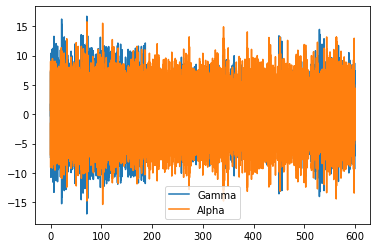

In [59]:
from matplotlib import pyplot as plt

plt.figure(1)
plt.plot(time, gamma, label='Gamma')
plt.plot(time, alpha, label='Alpha')
plt.legend()
plt.show()

In [60]:
def plot_spect(data, N, fs):
    freq_data = 2 * (np.fft.fft(data) / N)[:N//2+1]
    freqs = np.fft.fftfreq(N, 1/fs)[:N//2+1]
    plt.plot(freqs, np.abs(freq_data))
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.title('One-Sided Spectrum')
    plt.xlim([0, 45])
    plt.show()

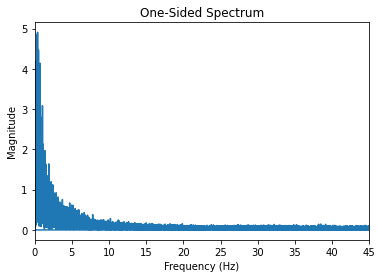

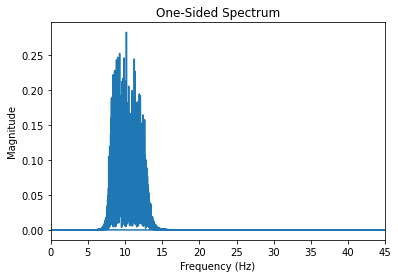

In [63]:
plot_spect(signal, N, fs)
plot_spect(alpha, N, fs)

#### Features

##### Mean

In [24]:
mean = np.mean(signal)
mean

0.08581846

##### Variance

In [64]:
var = np.var(alpha[0:10*fs])
var

12.176737696137948

##### STD

In [65]:
std = np.std(alpha[0:10*fs])
std

3.4895182613274787

##### Skewness

In [66]:
skew = ss.skew(alpha[0:10*fs])
skew

-0.005838878968600279

##### Kurtosis

In [67]:
kurt = ss.kurtosis(alpha[0:10*fs])
kurt

-0.38927940256560056

#### Comparing basic features between subjects

In [68]:
def get_subject_eeg(index, chanel):
    signal = data['ch' + str(chanel)][index][0]
    return signal

In [69]:
window = 5 # epoch length in seconds
overlap = 2.5 # length of overlap in seconds
window_length, overlap_length = int(window*fs), int(overlap*fs)

sub1, sub2 = 0, 41
signal0 = get_subject_eeg(sub1, 0)
signal1 = get_subject_eeg(sub2, 0)
print("MMSE score of first subject is {} and of second {}".format(data['MMSE'][sub1], data['MMSE'][sub2]))


TypeError: list indices must be integers or slices, not str

In [ ]:
plt.plot(bandpass_filter(signal0, 4, 8, fs)[100*fs:110*fs])
plt.plot(bandpass_filter(signal1, 4, 8, fs)[100*fs:110*fs])

### Comparing amplitudes of alpha and theta rhythms

In [73]:
alpha = np.empty((88, 1))
theta = np.empty((88, 1))
mmse = np.empty((88, 1))
for i in range(88):
    signal = get_subject_eeg(i, 0)
    alpha_signal = bandpass_filter(signal, 13, 30, fs)
    theta_signal = bandpass_filter(signal, 4, 8, fs)
    alpha[i] = np.sum(np.square(alpha_signal))/len(signal)
    theta[i] = np.sum(np.square(theta_signal))/len(signal)
    mmse[i] = data['MMSE'][i]

plt.figure(1)
plt.scatter(mmse, alpha)
plt.xlabel('mmse score')
plt.ylabel('power')
plt.title('power in alpha spectrum')
plt.figure(2)
plt.scatter(mmse, theta)
plt.xlabel('mmse score')
plt.ylabel('power')
plt.title('power in theta spectrum')


Text(0.5, 1.0, 'power in theta spectrum')